# Formula AI 2022 Hackathon
This is a submission for **Challenge 1: Data Analytics** by **Team Kaha**

Team memebers: 
* Austin Chamberlain
* Fernando Galetto
* Gul Hassan
* Rachel J Mah
* Sameer Joshi
* Waseem Waheed

# Data Analytics Challenge

The challenge description is provided **[here](https://github.com/oracle-devrel/formula-ai-2022-hackathon/blob/main/challenges/challenge1.md)**


In [ ]:
# Tools used

## Table of contents
* [1 Data preparation](#first-bullet)
* [2 AI/ML Model design](#second-bullet)
* [3 Model implementation](#third-bullet)

# 1 Data Preparation <a class="anchor" id="first-bullet"></a>

The data was provided in two formats: csv and json, we chose to use the csv format for convenience, the size of the file is easier to handle on a single machine.

The first step is loading the data:

In [1]:
import pandas as pd
raw_data = pd.read_csv('Data/weather.csv',low_memory=False)

The data provided was unnormalized to be layed out in csv file and contains a lot of duplications hence, the next step is to drop all the duplications

In [2]:
# Clean the data; 
raw_data.drop_duplicates(inplace=True)
raw_data.dropna(inplace=True, how='all')
# suggested filtering
raw_data.drop(raw_data.index[raw_data['M_NUM_WEATHER_FORECAST_SAMPLES'] == 0], inplace=True)

The data has a large number of columns but not all of the are relevant to the task, the next step is to define the columns of interest

In [3]:
cols_to_keep = ['M_SESSION_UID', 
                'TIMESTAMP', # timestamp for when the packet was received
                'M_SESSION_TYPE',
                'M_TRACK_TEMPERATURE', # Track temp. in degrees celsius
                'M_AIR_TEMPERATURE',
                'M_RAIN_PERCENTAGE',
                'M_WEATHER',
                'M_TIME_OFFSET',
                'M_WEATHER_FORECAST_SAMPLES_M_WEATHER',
                'M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE',
                'M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE',
                'M_TRACK_TEMPERATURE_CHANGE',
                'M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE',
                'M_AIR_TEMPERATURE_CHANGE',
                'M_TRACK_ID'
               ]
sess_pkt_data = raw_data[cols_to_keep].drop_duplicates()

Forcasts are provided at different for different intervals, and the goal is to produce a prediction at t+5, t+10, t+15, t+30 and t+60

In [4]:
sess_pkt_data['M_TIME_OFFSET'].unique()

array([ nan,   0.,   5.,  10.,  15.,  30.,  45.,  60.,  90., 120.])

A further reduction in the number of rows can be achieved by dropping the forecasts at offsets that are not relevant

In [5]:
# Remove rows with time_offsets not required. 
sess_pkt_data.drop(sess_pkt_data.index[sess_pkt_data['M_TIME_OFFSET'].isnull()==True], inplace=True)      
sess_pkt_data.drop(sess_pkt_data.index[sess_pkt_data['M_TIME_OFFSET'].isin([45, 90, 120])==True], inplace=True)      
sess_pkt_data['M_TIME_OFFSET'].unique()

array([ 0.,  5., 10., 15., 30., 60.])

Another data timestamp there are multiple predictions with same offsets, 

In [6]:
sess_pkt_data.groupby(['M_SESSION_UID','TIMESTAMP','M_SESSION_TYPE', 'M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE']).count()['M_TIME_OFFSET'].value_counts()

6    82653
1    35651
3    22311
Name: M_TIME_OFFSET, dtype: int64

Now that the data is ready to process, we need to check if the sessions are long enough to verify the accuracy of the game forecasts, this means we need to check if we have more than 1hr timestamps per session 

<AxesSubplot:>

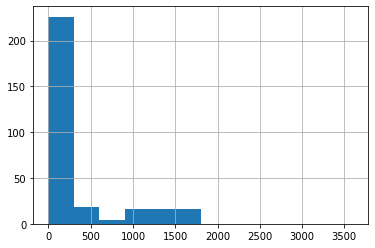

In [7]:
# Session duration, this is calculated using the number of timestamps available in the data keeping in mind that 1 timestamp is equivalent to 1 sec
sess_pkt_data[sess_pkt_data['M_TIME_OFFSET']==5].groupby(['M_SESSION_UID','M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE' ]).count()['TIMESTAMP'].hist(bins=[0,300, 600, 900, 1800, 3600])

Next, we save a copy of the data after the initial cleanup 

In [8]:
sess_pkt_data.to_csv('Data/cleaned_data.csv', index=False)

To be able to train a model to predict the weather and perciptation at t+5, t+10, t+15, t+30 and t+60, ground truth should be generated which can be found by looking at the timestamp 5 min ahead then 10 min ahead and so one. Some session lenghts are too short so a few cells of these new columns won't be populated. Nevertheless, we can use only the populated ones to train the model. 

**NOTE:** This process is iterative so it could take several minutes to complete. 

In [9]:
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display

ground_truth_data = sess_pkt_data.copy().reset_index(drop=True); # Array to iterate over rows. 

weather_gt = np.empty((ground_truth_data.shape[0])); # Array for weather values
rain_gt = np.empty((ground_truth_data.shape[0]));# Array for ran values. 

# Progress bar
f = IntProgress(value = 0, min=0, max=ground_truth_data.shape[0]) 
display(f) 

for index, c_row in ground_truth_data.iterrows():
    gt_timestamp = c_row['TIMESTAMP'] + c_row['M_TIME_OFFSET'] * 60; # Ground truth timestamp. M_TIME_OFFSET
    # find the Row of interest:
    roi = ground_truth_data[(ground_truth_data['M_SESSION_UID']==c_row['M_SESSION_UID']) \
              & (ground_truth_data['TIMESTAMP']==gt_timestamp) \
              & (ground_truth_data['M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE']==c_row['M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE']) \
              & (ground_truth_data['M_TIME_OFFSET']==0)]
    # if a raw complies with the condition save the values into the GT arrays. 
    try:
        weather_gt[index] = roi['M_WEATHER'].values[0]
        rain_gt[index] = roi['M_RAIN_PERCENTAGE'].values[0]
    except:
        weather_gt[index] = np.nan
        rain_gt[index] = np.nan
        continue
    # signal to increment the progress bar    
    f.value = index 

IntProgress(value=0, max=598502)

In [10]:
# Convert ground truth arrays to columns
ground_truth_data['GT_M_WEATHER'] = pd.Series(weather_gt)
ground_truth_data['GT_M_RAIN_PERCENTAGE'] = pd.Series(rain_gt)

The cleaned data is saved into a new csv file so the cleaning process do not need to be repeated. 

In [11]:
ground_truth_data.to_csv('Data/cleaned_data_gt.csv', index=False)

A sample of the data is showed below for reference: 

In [12]:
ground_truth_data.head()

,M_SESSION_UID,TIMESTAMP,M_SESSION_TYPE,M_TRACK_TEMPERATURE,M_AIR_TEMPERATURE,M_RAIN_PERCENTAGE,M_WEATHER,M_TIME_OFFSET,M_WEATHER_FORECAST_SAMPLES_M_WEATHER,M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,M_TRACK_TEMPERATURE_CHANGE,M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE,M_AIR_TEMPERATURE_CHANGE,M_TRACK_ID,GT_M_WEATHER,GT_M_RAIN_PERCENTAGE
0,2939734289500381614,1.642724e+09,8,33,25,1.0,0,0.0,0.0,8.0,33.0,2.0,25.0,2.0,28,0.0,1.0
1,2939734289500381614,1.642724e+09,8,33,25,1.0,0,5.0,0.0,8.0,33.0,2.0,25.0,2.0,28,0.0,1.0
2,2939734289500381614,1.642724e+09,8,33,25,2.0,0,10.0,0.0,8.0,33.0,2.0,25.0,2.0,28,0.0,2.0
3,2939734289500381614,1.642724e+09,8,33,25,5.0,0,0.0,1.0,10.0,32.0,1.0,24.0,1.0,28,0.0,5.0
4,2939734289500381614,1.642724e+09,8,33,25,5.0,0,5.0,1.0,10.0,32.0,2.0,24.0,2.0,28,0.0,5.0


# 2 AI/ML Model design <a class="anchor" id="second-bullet"></a>

We aimed to produce two ML models, one to predict the weather type and another to predict the rain percentage, we then will use aggregation to produce the output dictionary. 

We tackle the problem of **weather type prediction** as a classification problem. As initial approach we decided to use a Random Forest Classifier architecture to perform the task. Several models were trained to compare accuracy, each model contains the data for each interval (t+5, t+10, t+15, t+30 and t+60) and its predecessors. The idea is to evaluate if the prediction at t+60 has enough accuracy or affect the overall classifier performance. 

We conclude that one classifier can make the job as long as is trained with the forecast at all time offsets (t+5, t+10, t+15, t+30 and t+60) as long as the Time offset is used as a feature. 

The **rain percentage prediction** is tackled using regression. Using the whole range of samples we train two models a Decision Tree Regressor and a Random Forest Regressor. Both models presented a similar Mean Absolute Error so we decided to keep both. 



In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import pickle

Load the cleaned data:

In [21]:
clean_data = pd.read_csv('Data/cleaned_data_gt.csv',low_memory=False)

Next, create the list of features

In [22]:
features = ['M_TIME_OFFSET',
            'M_TRACK_TEMPERATURE',
            'M_AIR_TEMPERATURE',
            'M_RAIN_PERCENTAGE', 
            'M_WEATHER', 
            'M_WEATHER_FORECAST_SAMPLES_M_WEATHER',
            'M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE',
            'M_TRACK_TEMPERATURE_CHANGE',
            'M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE',
            'M_AIR_TEMPERATURE_CHANGE']

In [23]:
# model evaluation function
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # summarize performance
    print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [24]:
# model fitting function
def fit_model(X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    return model

## 2.1 Weather type prediction:

### 5 min prediction

In [25]:
df5min = clean_data[(clean_data['M_TIME_OFFSET'].isin([0,5])) & \
                    (clean_data['GT_M_WEATHER'].isnull() == False)]
X = df5min[features]
y = df5min['GT_M_WEATHER']
weather_model_5 = RandomForestClassifier(max_depth=4, class_weight='balanced')
evaluate_model(X, y, weather_model_5)

Mean Accuracy: 1.000 (0.000)


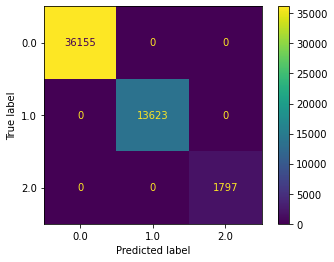

In [26]:
weather_model_5 = fit_model(X, y, weather_model_5)

### 10 min prediction

In [29]:
df10min = clean_data[(clean_data['M_TIME_OFFSET'].isin([0,5,10])) & \
             (clean_data['GT_M_WEATHER'].isnull() == False)]

X = df10min[features]
y = df10min['GT_M_WEATHER']
weather_model_10 = RandomForestClassifier(max_depth=4, class_weight='balanced')
evaluate_model(X, y, weather_model_10)

Mean Accuracy: 0.998 (0.000)


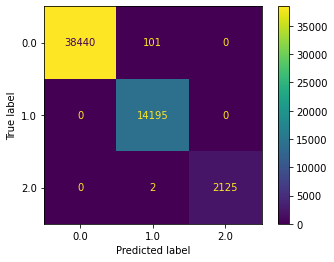

In [30]:
weather_model_10 = fit_model(X, y, weather_model_10)

### 15 min Prediction

In [32]:
# Weather 
df15min = clean_data[(clean_data['M_TIME_OFFSET'].isin([0,5,10,15])) & \
             (clean_data['GT_M_WEATHER'].isnull() == False)]
X = df15min[features]
y = df15min['GT_M_WEATHER']
weather_model_15 = RandomForestClassifier(max_depth=4, class_weight='balanced')
evaluate_model(X, y, weather_model_15)

Mean Accuracy: 0.997 (0.000)


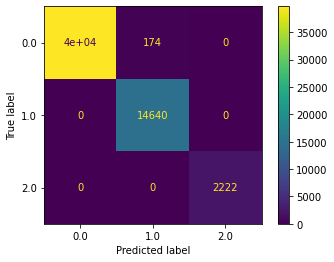

In [33]:
weather_model_15 = fit_model(X, y, weather_model_15)

### 30 min prediction

In [35]:
# Weather 
df30min = clean_data[(clean_data['M_TIME_OFFSET'].isin([0,5,10,15,30])) & \
             (clean_data['GT_M_WEATHER'].isnull() == False)]
X = df30min[features]
y = df30min['GT_M_WEATHER']
weather_model_30 = RandomForestClassifier(max_depth=4, class_weight='balanced')
evaluate_model(X, y, weather_model_30)

Mean Accuracy: 0.997 (0.000)


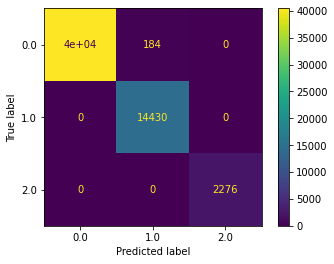

In [36]:
weather_model_30 = fit_model(X, y, weather_model_30)

### 60 Min prediction

We only need this model because it is able to predict all the forecasts since the time offset is an input, we need to evaluate how accurate is on each time offset. 

In [39]:
# Weather 
df60min = clean_data[(clean_data['M_TIME_OFFSET'].isin([5,10,15,60])) &
             (clean_data['GT_M_WEATHER'].isnull() == False)]
X = df60min[features]
y = df60min['GT_M_WEATHER']
weather_model_60 = RandomForestClassifier(max_depth=4, class_weight='balanced')
evaluate_model(X, y, weather_model_60)

Mean Accuracy: 0.997 (0.003)


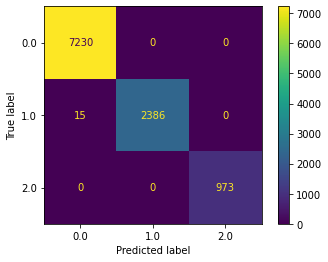

In [40]:
weather_model_60 = fit_model(X, y, weather_model_60)

Since the last model can predict the weather type at all time offsets we decided to keep it as a winner. 

In [41]:

# Save the model. 
import pickle
filename = 'Models/Weather_RandomForestClassifier.pkl'
# Open the file to save as pkl file
classifier_pkl = open(filename, 'wb')
pickle.dump(weather_model_60, classifier_pkl)
# Close the pickle instances
classifier_pkl.close()

We studied the feature importance for the classifier:

In [44]:
# Feature importance
feature_imp = pd.Series(weather_model_60.feature_importances_,index=features).sort_values(ascending=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


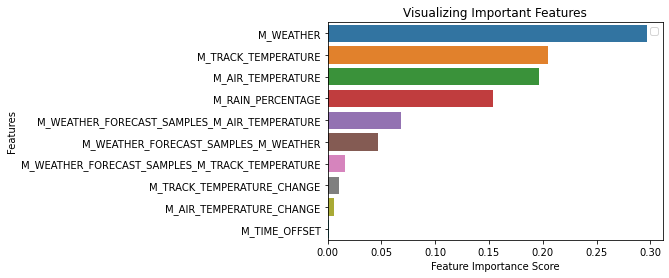

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## 2.2 Rain percentage prediction

The features used to predict the rain percentage are initially set to be the same as the features used for weather type prediction. This was decided for simplicity so the data do not need to be adapted twice. 


In [46]:
features_rain = [
            'M_TIME_OFFSET',
            'M_TRACK_TEMPERATURE',
            'M_AIR_TEMPERATURE',
            'M_RAIN_PERCENTAGE', 
            'M_WEATHER',  
            'M_WEATHER_FORECAST_SAMPLES_M_WEATHER',
            'M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE',
            'M_TRACK_TEMPERATURE_CHANGE',
            'M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE',
            'M_AIR_TEMPERATURE_CHANGE'
           ]

### 2.2.1 Model 1: Random Forest Regressor

In [56]:


# Refine the data. 
df60min = clean_data[(clean_data['M_TIME_OFFSET'].isin([5,10,15,30,60]))&(clean_data['GT_M_WEATHER'].isnull()==False)]
X = df60min[features_rain]
y = df60min['GT_M_RAIN_PERCENTAGE']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)




In [57]:
from sklearn.ensemble import RandomForestRegressor

model_1 = RandomForestRegressor()

# Fit the model
model_1.fit(X_train, y_train)

# prediction on test set
y_pred=model_1.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))



Mean Absolute Error: 0.1335189012661938
Mean Squared Error: 0.16241826263631384
Root Mean Squared Error: 0.40301149194075575


In [58]:
# Save the model. 
filename = 'Models/Rain_RandomForestRegressor.pkl'
# Open the file to save as pkl file
regressor_pkl = open(filename, 'wb')
pickle.dump(model_1, regressor_pkl)
# Close the pickle instances
regressor_pkl.close()

 Visualize the feature importance 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


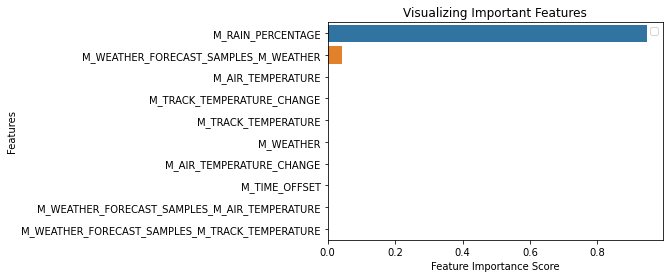

In [59]:
# Feature importance
import pandas as pd
feature_imp = pd.Series(model_1.feature_importances_,index=features_rain).sort_values(ascending=False)
feature_imp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()


### 2.2.1 Model 2: DecisionTreeRegressor

In [68]:
from sklearn.tree import DecisionTreeRegressor
model_2 = DecisionTreeRegressor()

# Fit the model
model_2.fit(X_train, y_train)

# prediction on test set
y_pred=model_2.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.1336481772416192
Mean Squared Error: 0.16233357803837917
Root Mean Squared Error: 0.4029064134986922


In [72]:
# Save the model. 
filename = 'Models/Rain_DecisionTreeRegressor.pkl'
# Open the file to save as pkl file
regressor_pkl = open(filename, 'wb')
pickle.dump(model_2, regressor_pkl)
# Close the pickle instances
regressor_pkl.close()



 Visualize the feature importance 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


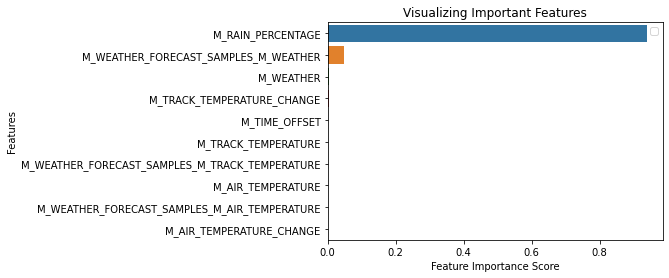

In [73]:
# Feature importance
import pandas as pd
feature_imp = pd.Series(model_2.feature_importances_,index=features).sort_values(ascending=False)
feature_imp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()



# 3 MODEL IMPLEMENTATION <a class="anchor" id="third-bullet"></a>


Both models previously proposed to forecast the wheather type and rain percentage are join together to produce the decired output dictionary. 

In [74]:
import pandas as pd
import json


# Load the data
DATASET = pd.read_csv('Data/cleaned_data_gt.csv',low_memory=False)

# Loading the saved models pickle
model_weather_pkl = open('Models/Weather_RandomForestClassifier.pkl', 'rb')
model_weather = pickle.load(model_weather_pkl)
print("Loaded weather forecast model :: ", model_weather)
model_rain_pkl = open('Models/Rain_DecisionTreeRegressor.pkl', 'rb')
model_rain = pickle.load(model_rain_pkl)
print("Loaded rain probability forecast model :: ", model_rain)


def select_sample(DATA, session_uid, session_type, timestamp):
    # This function filter the features from the data, a session_uid, session_type and timestamp need to be provided. 
    features = ['M_TIME_OFFSET','M_TRACK_TEMPERATURE','M_AIR_TEMPERATURE','M_RAIN_PERCENTAGE',
                'M_WEATHER','M_WEATHER_FORECAST_SAMPLES_M_WEATHER','M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE',
                'M_TRACK_TEMPERATURE_CHANGE','M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE','M_AIR_TEMPERATURE_CHANGE']
    D = DATA[(DATA['M_SESSION_UID']==session_uid) & 
                (DATA['TIMESTAMP']==timestamp) &
                (DATA['M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE']==session_type)&
                 (DATA['M_TIME_OFFSET']>0)];
    
    # filter features for each model.
    sample = D[features].reset_index(drop=True);
    return sample

def get_forecast(DATA_SAMPLE):
    # This function makes the prediction of weather type and rain percentage and produces the output dictionary. 
    print('\nPredicting...\n') 
    prediction ={}
    # make the predictions. 
    weather_prediction = model_weather.predict(DATA_SAMPLE)
    rain_prediction = model_rain.predict(DATA_SAMPLE)/100
    # extract the data and create dictionary. 
    
    time_offsets = DATA_SAMPLE['M_TIME_OFFSET'].unique();
    
    for t in range(len(time_offsets)):
        idx = DATA_SAMPLE.index[DATA_SAMPLE['M_TIME_OFFSET'] == time_offsets[t]].tolist()
        prediction[str(int(time_offsets[t]))] = {'type':int(weather_prediction[idx[0]]),'rain_percentage':rain_prediction[idx[0]] }
    return prediction

data_sample = select_sample(DATASET, session_uid=10929277407573190380, session_type=10, timestamp=1642132948)
prediction = get_forecast(data_sample)

# Print the result dictionary. 
print("\nInference Resul:\n")
print(json.dumps(prediction, indent=2))

Loaded weather forecast model ::  RandomForestClassifier(class_weight='balanced', max_depth=4)
Loaded rain probability forecast model ::  DecisionTreeRegressor()

Predicting...


Inference Resul:

{
  "5": {
    "type": 2,
    "rain_percentage": 0.16
  },
  "10": {
    "type": 2,
    "rain_percentage": 0.16
  },
  "15": {
    "type": 2,
    "rain_percentage": 0.16
  },
  "30": {
    "type": 2,
    "rain_percentage": 0.11
  },
  "60": {
    "type": 2,
    "rain_percentage": 0.03
  }
}
